Useful link:
- https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html#centrography

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm # for linear regression

import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from pointpats import centrography # for centrographic statistics
from matplotlib.patches import Ellipse # for standard deviational ellipse
import contextily


%matplotlib inline

### Clean MPV data to be just NYC

In [4]:
# read in the raw data from MappingPoliceViolence.org
mpv_raw = pd.read_csv('/Users/taylor/Desktop/phd/research-local/data/police-violence-data/MPV03282023.csv')
mpv_raw.head()

,name,age,gender,race,victim_image,date,street_address,city,state,zip,...,congressperson_party,prosecutor_head,prosecutor_race,prosecutor_gender,prosecutor_party,prosecutor_term,prosecutor_in_court,prosecutor_special,independent_investigation,prosecutor_url
0,Jesus Antonio Rodriguez,33.0,Male,Hispanic,https://i0.wp.com/nbcpalmsprings.com/wp-conten...,2/6/2023,25400 block of Filaree Ave,Moreno Valley,CA,92551.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Evan Wollert,44.0,Male,Black,https://d1ldvf68ux039x.cloudfront.net/thumbs/f...,2/6/2023,3985 East Bijou Street,Colorado Springs,CO,80909.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alex Greene,21.0,Male,NaN,https://cache.legacy.net/legacy/images/cobrand...,2/6/2023,Havendale Boulevard near 16th Street,Winter Haven,FL,33881.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Azaan Lee,21.0,Male,Black,https://encrypted-tbn0.gstatic.com/images?q=tb...,2/6/2023,200 block of Campbell Ave.,Rantoul,IL,61866.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Antonio Garza,44.0,Male,NaN,NaN,2/5/2023,"Whitewater Cutoff, north of the 10 Freeway",Palm Springs,CA,92282.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# exploring the data
mpv_raw.columns

Index(['name', 'age', 'gender', 'race', 'victim_image', 'date',
       'street_address', 'city', 'state', 'zip', 'county',
       'agency_responsible', 'ori', 'cause_of_death', 'circumstances',
       'disposition_official', 'officer_charged', 'news_urls',
       'signs_of_mental_illness', 'allegedly_armed', 'wapo_armed',
       'wapo_threat_level', 'wapo_flee', 'wapo_body_camera', 'wapo_id',
       'off_duty_killing', 'geography', 'mpv_id', 'fe_id', 'encounter_type',
       'initial_reason', 'officer_names', 'officer_races',
       'officer_known_past_shootings', 'call_for_service', 'tract',
       'urban_rural_uspsai', 'urban_rural_nchs',
       'hhincome_median_census_tract', 'latitude', 'longitude',
       'pop_total_census_tract', 'pop_white_census_tract',
       'pop_black_census_tract', 'pop_native_american_census_tract',
       'pop_asian_census_tract', 'pop_pacific_islander_census_tract',
       'pop_other_multiple_census_tract', 'pop_hispanic_census_tract',
       'congressio

In [6]:
mpv_raw['state'].unique()

array(['CA', 'CO', 'FL', 'IL', 'IN', 'MA', 'AL', 'NJ', 'TX', 'KS', 'KY',
       'LA', 'MI', 'SD', 'GA', 'SC', 'TN', 'VA', 'MO', 'NE', 'OH', 'NM',
       'MD', 'AZ', 'ID', 'AR', 'OR', 'WA', 'MS', 'WI', 'PA', 'NC', 'OK',
       'UT', 'WV', 'NY', 'NV', 'NH', 'HI', 'IA', 'AK', 'MN', 'DC', 'DE',
       'WY', 'CT', 'MT', 'ME', 'VT', 'ND', 'RI'], dtype=object)

In [7]:
# filtering data to New York State
mpv_nys = mpv_raw[mpv_raw['state'] == 'NY']
mpv_nys

,name,age,gender,race,victim_image,date,street_address,city,state,zip,...,congressperson_party,prosecutor_head,prosecutor_race,prosecutor_gender,prosecutor_party,prosecutor_term,prosecutor_in_court,prosecutor_special,independent_investigation,prosecutor_url
100,Christopher T. Torres,34.0,Male,NaN,NaN,1/10/2023,Fields Corner Road near Pugsley Road,Southeast,NY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,Quayshawn Samuel,31.0,Male,NaN,NaN,12/29/2022,439 Beach 56th,Queens,NY,11692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,Enrique Lopez,56.0,Male,NaN,NaN,12/28/2022,Birchwood Road,Medford,NY,11763.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,Chatuma M. Crawford,20.0,Male,NaN,NaN,12/17/2022,Northern Blvd.,Cicero,NY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,Daniel Rivera,39.0,Male,Hispanic,NaN,12/4/2022,161st Street and Summit Avenue,New York,NY,10451.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11130,Kurt Myers,64.0,Male,White,http://ww2.hdnux.com/photos/20/36/45/4319577/2...,3/14/2013,248 N Main St,Herkimer,NY,13350.0,...,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11142,Kimani Gray,16.0,Male,Black,NaN,3/10/2013,East 52nd St and Snyder Avenue,New York,NY,11218.0,...,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11165,Richard J. Aubin,28.0,Male,White,http://usgunviolence.files.wordpress.com/2013/...,3/5/2013,Liberty Road and Route 9,North Hudson,NY,12855.0,...,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11207,Charles A. Baker Jr.,30.0,Male,Black,http://www.buffalonews.com/storyimage/BN/20130...,2/16/2013,201 E 2nd St,Jamestown,NY,14701.0,...,Republican,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


236 observations of police violence in New York State (even less in New York City, presumably). 

In [8]:
mpv_nys['county'].unique()

array(['Putnam', 'Queens', 'Suffolk', 'Onondaga', 'Bronx', 'Erie',
       'Nassau', 'New York', 'Monroe', 'Kings', 'Oneida', 'Ulster',
       'Franklin', 'Orange', 'Dutchess', 'Westchester', 'Herkimer',
       'Otsego', 'Greene', 'Delaware', 'Cayuga', 'King', 'Chemung',
       'Rensselaer', nan, 'Wayne', 'Livingston', 'Schenectady',
       'Rockland', 'Tompkins', 'Hamilton', 'Richmond', 'Broome',
       'Chautauqua', 'Albany', 'Genesee', 'Madison', 'Ontario',
       'St. Lawrence', 'Fulton', 'Oswego', 'Orleans', 'Saratoga', 'Essex'],
      dtype=object)

In [9]:
# filtering to only NYC counties
mpv_nyc = mpv_nys[(mpv_nys['county'] == 'Queens') |
                 (mpv_nys['county'] == 'Richmond')|
                 (mpv_nys['county'] == 'New York')|
                 (mpv_nys['county'] == 'Kings')|
                 (mpv_nys['county'] == 'Bronx')
                 ]
# sanity check to make sure it's only NYC counties
mpv_nyc['county'].unique()

array(['Queens', 'Bronx', 'New York', 'Kings', 'Richmond'], dtype=object)

In [10]:
mpv_nyc

,name,age,gender,race,victim_image,date,street_address,city,state,zip,...,congressperson_party,prosecutor_head,prosecutor_race,prosecutor_gender,prosecutor_party,prosecutor_term,prosecutor_in_court,prosecutor_special,independent_investigation,prosecutor_url
154,Quayshawn Samuel,31.0,Male,NaN,NaN,12/29/2022,439 Beach 56th,Queens,NY,11692.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,Daniel Rivera,39.0,Male,Hispanic,NaN,12/4/2022,161st Street and Summit Avenue,New York,NY,10451.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293,Name Withheld,NaN,Male,NaN,NaN,11/18/2022,72 Vermilyea Ave,New York,NY,10034.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323,Jermaine Hickson,42.0,Male,Black,https://www.google.com/url?sa=i&url=https%3A%2...,11/10/2022,West 36th Street and Neptune Avenue,New York,NY,11224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
345,Kyle Styles Lovera Lockett,21.0,Male,NaN,https://i2.wp.com/www.norwoodnews.org/wp-conte...,11/3/2022,330 East Gun Hill Road,Bronx,NY,10467.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10971,Deion Fludd,17.0,Male,Black,http://i.dailymail.co.uk/i/pix/2014/04/11/arti...,5/5/2013,Rockaway Avenue and Fulton Street,New York,NY,11233.0,...,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11046,Dylan Samuel-Peters,1.0,Male,Black,NaN,4/15/2013,East 56th Street in the East Flatbush,Brooklyn,NY,11203.0,...,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11047,Dason Peters,33.0,Male,Black,NaN,4/15/2013,East 56th Street in the East Flatbush,Brooklyn,NY,11203.0,...,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11142,Kimani Gray,16.0,Male,Black,NaN,3/10/2013,East 52nd St and Snyder Avenue,New York,NY,11218.0,...,Democrat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


100 observations of police violence in New York City across all 5 counties since 2013

### Clean MPV date column

In [11]:
# convert date column to datetime object and THEN sort it
mpv_nyc['date_new'] = pd.to_datetime(mpv_nyc['date'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
mpv_nyc['date_new']

154     2022-12-29
237     2022-12-04
293     2022-11-18
323     2022-11-10
345     2022-11-03
           ...    
10971   2013-05-05
11046   2013-04-15
11047   2013-04-15
11142   2013-03-10
11326   2013-01-03
Name: date_new, Length: 100, dtype: datetime64[ns]

In [13]:
# columns we care about for now: name, age, gender, race, date, city, zip, county, longitude, latitude, cause_of_death
mpv_nyc_clean = mpv_nyc[['name','age','gender','race','date_new','county','tract','longitude','latitude','cause_of_death']]
mpv_nyc_clean


,name,age,gender,race,date_new,county,tract,longitude,latitude,cause_of_death
154,Quayshawn Samuel,31.0,Male,NaN,2022-12-29,Queens,NaN,-73.786248,40.594928,Gunshot
237,Daniel Rivera,39.0,Male,Hispanic,2022-12-04,Bronx,6302.0,-73.927844,40.829298,Gunshot
293,Name Withheld,NaN,Male,NaN,2022-11-18,New York,29100.0,-73.923477,40.865709,Gunshot
323,Jermaine Hickson,42.0,Male,Black,2022-11-10,Kings,33000.0,-74.002157,40.577008,Gunshot
345,Kyle Styles Lovera Lockett,21.0,Male,NaN,2022-11-03,Bronx,43102.0,-73.873480,40.878858,Gunshot
...,...,...,...,...,...,...,...,...,...,...
10971,Deion Fludd,17.0,Male,Black,2013-05-05,Kings,37100.0,-73.910799,40.678278,Beaten
11046,Dylan Samuel-Peters,1.0,Male,Black,2013-04-15,Kings,93800.0,-73.924197,40.649604,Gunshot
11047,Dason Peters,33.0,Male,Black,2013-04-15,Kings,93800.0,-73.924197,40.649604,Gunshot
11142,Kimani Gray,16.0,Male,Black,2013-03-10,Kings,10000.0,-73.970771,40.757544,Gunshot


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

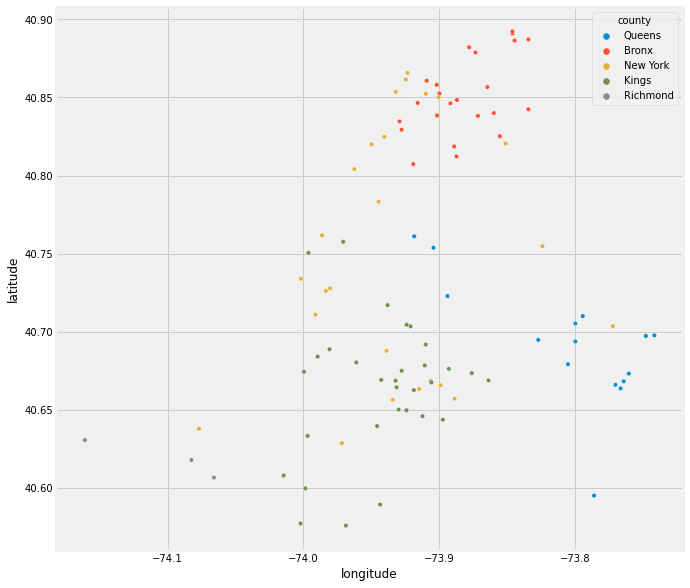

In [14]:
# exploratory scatter plot of the killings based on long and lat
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='county',s=20, data=mpv_nyc_clean)


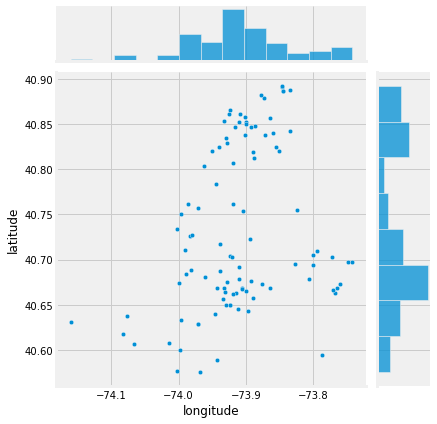

In [15]:
# Generate scatter plot
sns.jointplot(x="longitude", y="latitude", data=mpv_nyc_clean, s=20);

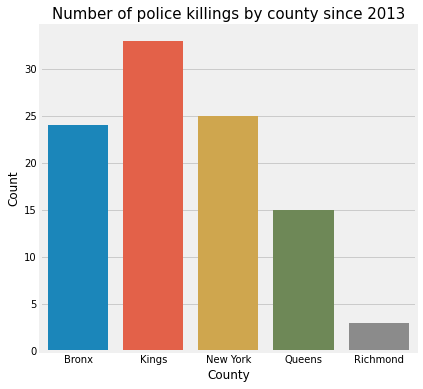

In [16]:
#Get a count by county
county_count = mpv_nyc_clean.groupby('county').agg('count').reset_index()

#Plot the count by county
fig, ax1 = plt.subplots(1,1, figsize=(6,6)
                       )
sns.barplot(x='county', y='name', data=county_count, ax=ax1)

ax1.set_title('Number of police killings by county since 2013', fontsize=15)
ax1.set_xlabel('County', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)

/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'NYC shape file')

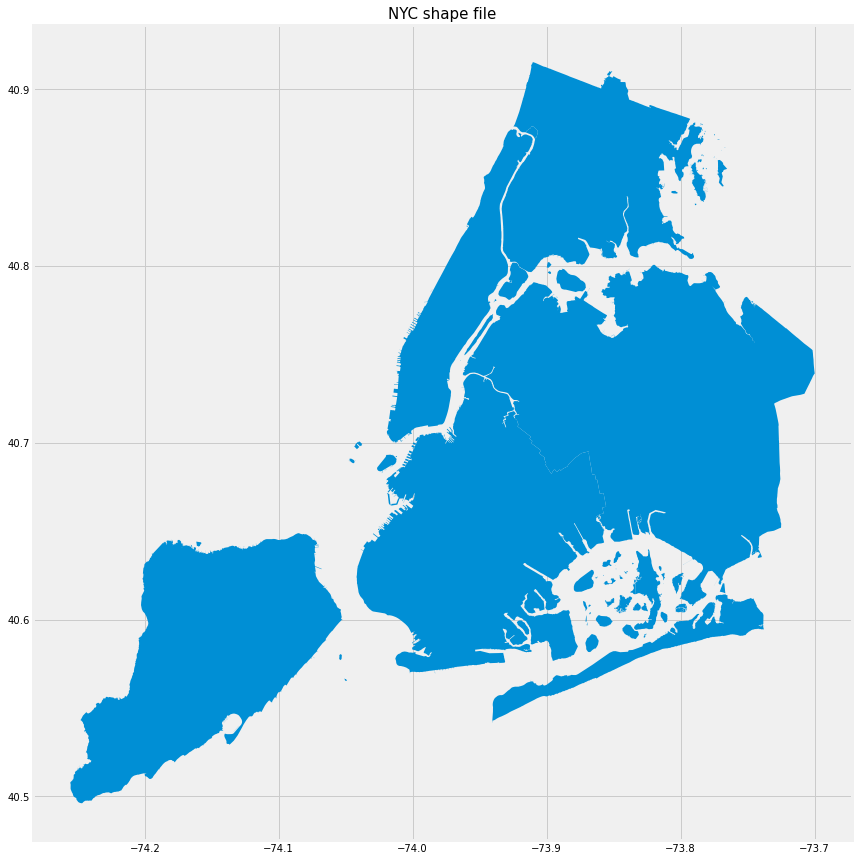

In [17]:
# read in the shapefile for NYC and plot bare map
nyc_map = gpd.read_file('/Users/taylor/Desktop/phd/research-local/data/shapefiles/nyc/nyc-shapefile-with-borough-lines/geo_export_712ccf97-7583-4635-9e4e-49905e30e6f4.shp')

fig, ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax)

ax.set_title('NYC shape file', fontsize=15)

In [18]:
# initialize coordinate reference system; there are different crs for different places
crs = {'init':'epsg:2263'}

In [48]:
mpv_nyc_clean_from_R = pd.read_csv("/Users/taylor/Desktop/phd/coursework/fall2023/gis-spatial/hw6/mpv_nyc_clean.csv")
mpv_nyc_clean_from_R.columns


Index(['name', 'age', 'gender', 'race', 'victim_image', 'date',
       'street_address', 'city', 'state', 'zip', 'county',
       'agency_responsible', 'ori', 'cause_of_death', 'circumstances',
       'disposition_official', 'officer_charged', 'news_urls',
       'signs_of_mental_illness', 'allegedly_armed', 'wapo_armed',
       'wapo_threat_level', 'wapo_flee', 'wapo_body_camera', 'wapo_id',
       'off_duty_killing', 'geography', 'mpv_id', 'fe_id', 'encounter_type',
       'initial_reason', 'officer_names', 'officer_races',
       'officer_known_past_shootings', 'call_for_service', 'tract',
       'urban_rural_uspsai', 'urban_rural_nchs',
       'hhincome_median_census_tract', 'latitude', 'longitude',
       'pop_total_census_tract', 'pop_white_census_tract',
       'pop_black_census_tract', 'pop_native_american_census_tract',
       'pop_asian_census_tract', 'pop_pacific_islander_census_tract',
       'pop_other_multiple_census_tract', 'pop_hispanic_census_tract',
       'congressio

In [19]:
# use longitude and latitude to create the 'geometry' variable
geometry = [Point(xy) for xy in zip(mpv_nyc_clean['longitude'], mpv_nyc_clean['latitude'])]


In [49]:
# use longitude and latitude to create the 'geometry' variable
geometry_R_dataset = [Point(xy) for xy in zip(mpv_nyc_clean_from_R['longitude'], mpv_nyc_clean_from_R['latitude'])]

# converting the pandas dataframe to a geodataframe, which uses longitude and latitude to create 'geometry variable'
mpv_nyc_clean_from_R_geo_df = gpd.GeoDataFrame(mpv_nyc_clean_from_R, #specify  data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry_R_dataset) #specify the geometry list we created

# take a look at the gdf with 'geometry' variable and all the data from the R dataset
mpv_nyc_clean_from_R_geo_df


/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,age,gender,race,victim_image,date,street_address,city,state,zip,...,prosecutor_head,prosecutor_race,prosecutor_gender,prosecutor_party,prosecutor_term,prosecutor_in_court,prosecutor_special,independent_investigation,prosecutor_url,geometry
0,Daniel Rivera,39.0,Male,Hispanic,NaN,12/4/2022,161st Street and Summit Avenue,New York,NY,10451.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.928 40.829)
1,Jermaine Hickson,42.0,Male,Black,https://www.google.com/url?sa=i&url=https%3A%2...,11/10/2022,West 36th Street and Neptune Avenue,New York,NY,11224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-74.002 40.577)
2,Joel Capellan,29.0,Male,Black,https://newyorkfolk.com/wp-content/uploads/202...,10/16/2022,Nagle Avenue and Dyckman Street,New York,NY,10040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.925 40.862)
3,Raul Hardy,60.0,Male,Hispanic,https://nypost.com/2022/07/10/nyc-man-shot-by-...,7/9/2022,205-17 116th Ave,Queens,NY,11412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.748 40.697)
4,Malik Williams,19.0,Male,Black,NaN,7/9/2022,Flatbush Avenue and Nevins Street,Brooklyn,NY,11217.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.981 40.689)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Deion Fludd,17.0,Male,Black,http://i.dailymail.co.uk/i/pix/2014/04/11/arti...,5/5/2013,Rockaway Avenue and Fulton Street,New York,NY,11233.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.911 40.678)
93,Dylan Samuel-Peters,1.0,Male,Black,NaN,4/15/2013,East 56th Street in the East Flatbush,Brooklyn,NY,11203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.924 40.650)
94,Dason Peters,33.0,Male,Black,NaN,4/15/2013,East 56th Street in the East Flatbush,Brooklyn,NY,11203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.924 40.650)
95,Kimani Gray,16.0,Male,Black,NaN,3/10/2013,East 52nd St and Snyder Avenue,New York,NY,11218.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-73.971 40.758)


In [20]:
# converting the pandas dataframe to a geodataframe, which uses longitude and latitude to create 'geometry variable'
mpv_nyc_geo_df = gpd.GeoDataFrame(mpv_nyc_clean, #specify  data
                          crs=crs, #specify our coordinate reference system
                          geometry=geometry) #specify the geometry list we created

# take a look at the df with 'geometry' variable
mpv_nyc_geo_df


/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,name,age,gender,race,date_new,county,tract,longitude,latitude,cause_of_death,geometry
154,Quayshawn Samuel,31.0,Male,NaN,2022-12-29,Queens,NaN,-73.786248,40.594928,Gunshot,POINT (-73.786 40.595)
237,Daniel Rivera,39.0,Male,Hispanic,2022-12-04,Bronx,6302.0,-73.927844,40.829298,Gunshot,POINT (-73.928 40.829)
293,Name Withheld,NaN,Male,NaN,2022-11-18,New York,29100.0,-73.923477,40.865709,Gunshot,POINT (-73.923 40.866)
323,Jermaine Hickson,42.0,Male,Black,2022-11-10,Kings,33000.0,-74.002157,40.577008,Gunshot,POINT (-74.002 40.577)
345,Kyle Styles Lovera Lockett,21.0,Male,NaN,2022-11-03,Bronx,43102.0,-73.873480,40.878858,Gunshot,POINT (-73.873 40.879)
...,...,...,...,...,...,...,...,...,...,...,...
10971,Deion Fludd,17.0,Male,Black,2013-05-05,Kings,37100.0,-73.910799,40.678278,Beaten,POINT (-73.911 40.678)
11046,Dylan Samuel-Peters,1.0,Male,Black,2013-04-15,Kings,93800.0,-73.924197,40.649604,Gunshot,POINT (-73.924 40.650)
11047,Dason Peters,33.0,Male,Black,2013-04-15,Kings,93800.0,-73.924197,40.649604,Gunshot,POINT (-73.924 40.650)
11142,Kimani Gray,16.0,Male,Black,2013-03-10,Kings,10000.0,-73.970771,40.757544,Gunshot,POINT (-73.971 40.758)


/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'Police killings in NYC since 2013')

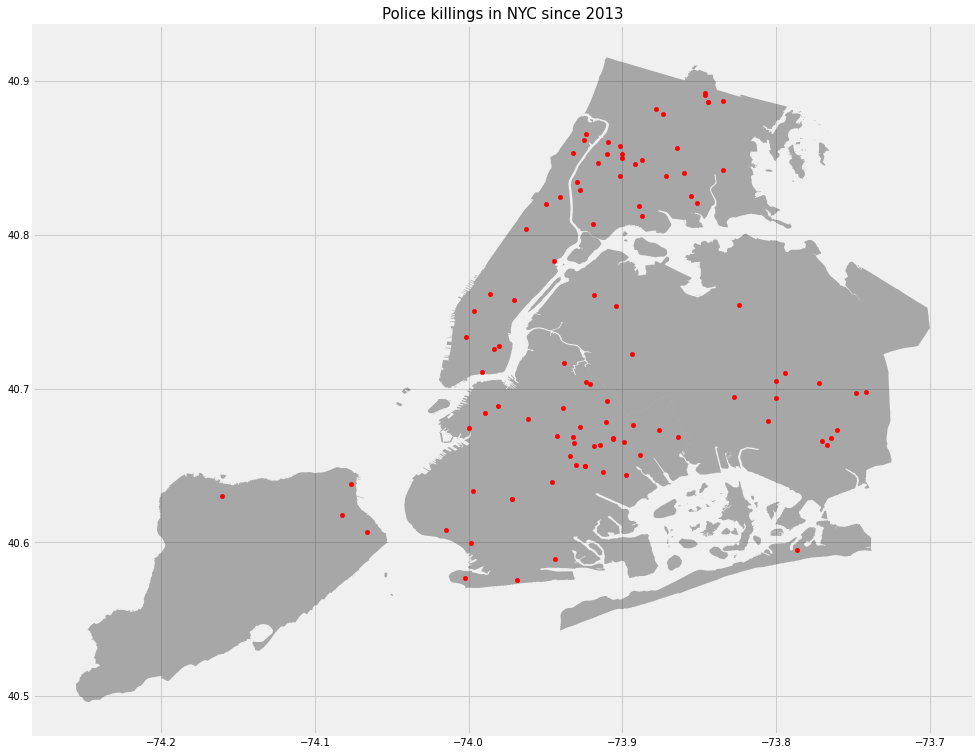

In [21]:
# add these points to the map from above
fig, ax1 = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax1, alpha=0.3, color='black')
mpv_nyc_geo_df.plot(ax=ax1, 
            markersize=20, 
            color='red', 
            marker='o')

# label the points with the date that they occurred
#for x, y, label in zip(mpv_nyc_geo_df.geometry.x, mpv_nyc_geo_df.geometry.y):
 #   ax1.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")

#plt.legend(prop={'size':15})

# set title
ax1.set_title('Police killings in NYC since 2013', fontsize=15)


In [52]:
mpv_nyc_clean_from_R_geo_df.dtype # so it's a geodataframe

AttributeError: 'GeoDataFrame' object has no attribute 'dtype'

In [57]:
# export geodataframe to shapefile
mpv_nyc_clean_from_R_geo_df_shp = mpv_nyc_clean_from_R_geo_df[['age', 'race', 'gender', 'encounter_type', 'county', 'allegedly_armed']]

filepath = "/Users/taylor/Desktop/phd/coursework/fall2023/gis-spatial/hw6"

import fiona
mpv_nyc_clean_from_R_geo_df_shp.to_file(f"{filepath}/mpv_nyc_clean_from_R_geo_df_shp.shp.shp", driver='ESRI Shapefile')


AttributeError: 'DataFrame' object has no attribute 'to_file'

/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



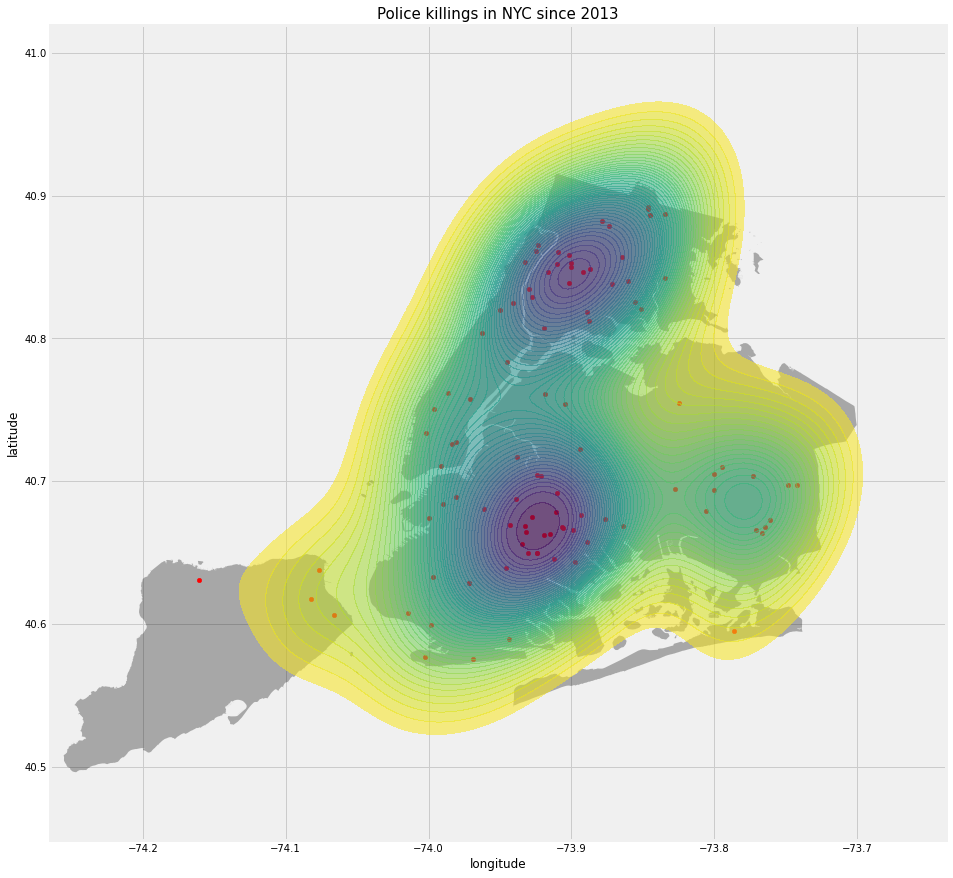

In [22]:
# add these points to the map from above
fig, ax2 = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax2, alpha=0.3, color='black')
mpv_nyc_geo_df.plot(ax=ax2, 
            markersize=20, 
            color='red', 
            marker='o')

# label the points with the date that they occurred
#for x, y, label in zip(mpv_nyc_geo_df.geometry.x, mpv_nyc_geo_df.geometry.y):
 #   ax1.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")

#plt.legend(prop={'size':15})

# set title
ax2.set_title('Police killings in NYC since 2013', fontsize=15)


# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
sns.kdeplot(
    x="longitude",
    y="latitude",
    data=mpv_nyc_clean,
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)

# Remove axes
ax.set_axis_off()

In [23]:
#The rows of our dataset are borough,
#so we iterate through each borough


#Add counts of stations per neighborhood
for county in nyc_map.index:
    mask = mpv_nyc_geo_df.within(nyc_map.loc[county, "geometry"])
    killings_count = mask.sum()
    nyc_map.loc[county, "killings_count"] = killings_count

In [24]:
# checking killings count per county/borough
nyc_map.describe()

,boro_code,shape_area,shape_leng,killings_count
count,5.000000,5.000000e+00,5.000000,5.000000
mean,3.000000,1.684576e+09,552611.743115,20.000000
std,1.581139,9.017828e+08,245398.447747,12.980755
min,1.000000,6.365208e+08,325917.353702,4.000000
25%,2.000000,1.187175e+09,357564.316391,14.000000
50%,3.000000,1.623621e+09,463179.772813,17.000000
75%,4.000000,1.934143e+09,728197.541089,27.000000
max,5.000000,3.041419e+09,888199.731579,38.000000


# Centrographic Stats on just MPV

In [25]:
# centrographic statistics
mean_center = centrography.mean_center(mpv_nyc_geo_df[["longitude", "latitude"]])
med_center = centrography.euclidean_median(mpv_nyc_geo_df[["longitude", "latitude"]])

In [26]:
centrography.std_distance(mpv_nyc_clean[["longitude", "latitude"]])

0.1176027051661323

In [27]:
major, minor, rotation = centrography.ellipse(mpv_nyc_clean[["longitude", "latitude"]])

/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


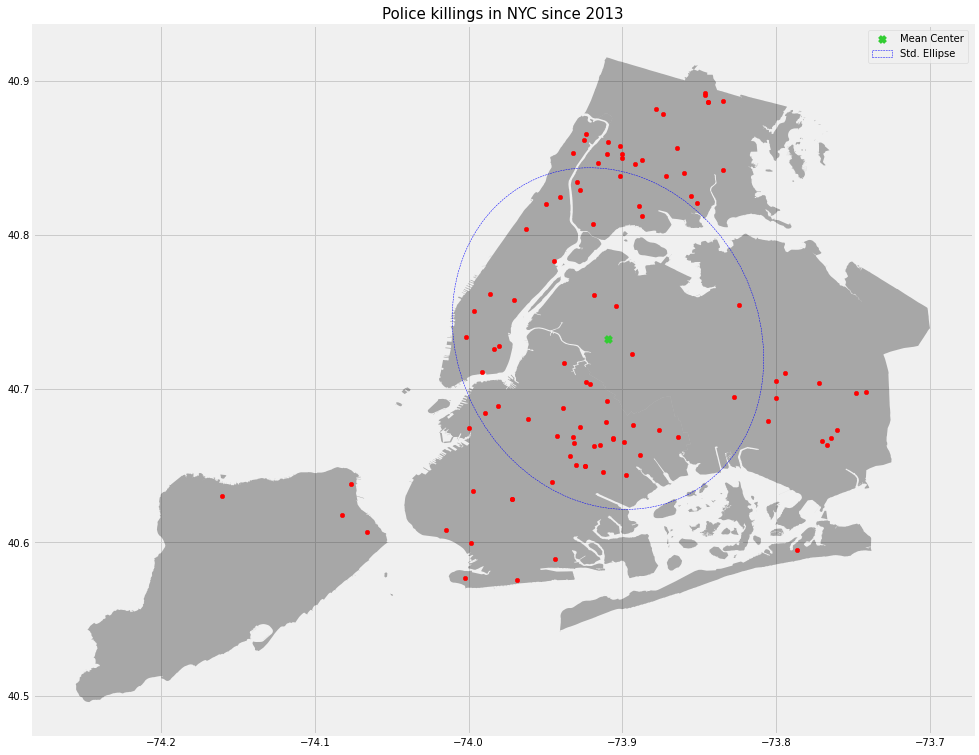

In [28]:
# add these points to the map from above
fig, ax3 = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax3, alpha=0.3, color='black')
mpv_nyc_geo_df.plot(ax=ax3, 
            markersize=20, 
            color='red', 
            marker='o')

# set title
ax3.set_title('Police killings in NYC since 2013', fontsize=15)

# plot mean center
ax3.scatter(*mean_center, color="limegreen", marker="x", label="Mean Center")


# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="blue",
    linestyle="--",
    label="Std. Ellipse",
)
ax3.add_patch(ellipse)

ax3.legend()
# Display
plt.show()

In [29]:
mean_center

array([-73.90944376,  40.73256801])

In [30]:
nyc_fatal_shootings_raw = pd.read_csv('/Users/taylor/Desktop/phd/research-local/data/crime-data/low-nyc/AV.org - Fatal Shootings NYC for 2010 − 2022.csv.csv')
nyc_fatal_shootings_raw

,date,tract_id,state_abr,crime_type,crimeCount,month,year,population
0,2022-12-01,36005001600,NY,400,1,12,2022,6144
1,2016-04-01,36005001600,NY,400,1,4,2016,6056
2,2022-01-01,36005001902,NY,400,1,1,2022,1464
3,2017-02-01,36005001902,NY,400,1,2,2017,1334
4,2019-11-01,36005002001,NY,400,1,11,2019,4837
...,...,...,...,...,...,...,...,...
1738,2020-09-01,36085031902,NY,400,2,9,2020,4953
1739,2019-10-01,36085031902,NY,400,1,10,2019,5343
1740,2014-06-01,36085031902,NY,400,1,6,2014,4535
1741,2020-07-01,36085032300,NY,400,1,7,2020,1200


/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'NYC public housing')

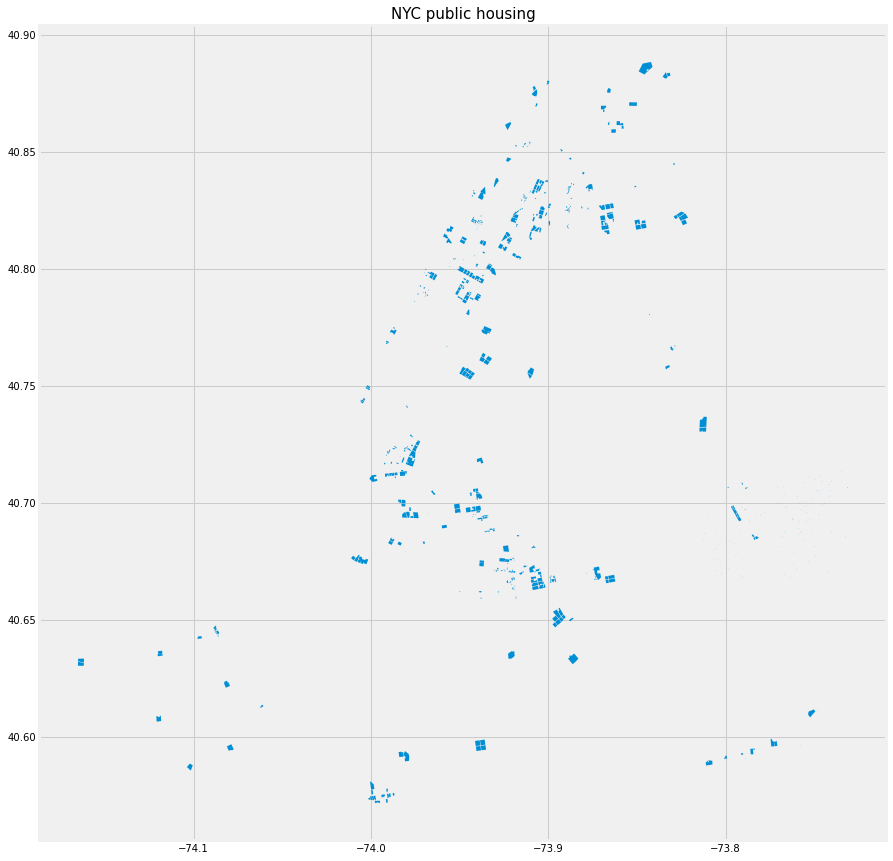

In [31]:
# let's look at a map of NYC housing projects
# read in the shapefile for NYC projects
nyc_public_housing = gpd.read_file('/Users/taylor/Desktop/phd/research-local/data/shapefiles/nyc/Map of NYCHA Developments/geo_export_a8617639-f8c6-4ee8-8710-a9b8391d9ba2.shp')

fig, ax = plt.subplots(figsize=(15,15))
nyc_public_housing.plot(ax=ax)

ax.set_title('NYC public housing', fontsize=15)

In [32]:
nyc_public_housing.describe()

,borough,developmen,tds_num,geometry
count,267,277,277,277
unique,5,277,277,277
top,MANHATTAN,1010 EAST 178TH STREET,180,POLYGON ((-73.88092067297234 40.84049546124294...
freq,82,1,1,1


In [33]:
nyc_public_housing

,borough,developmen,tds_num,geometry
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((-73.88092 40.84050, -73.88068 40.840..."
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((-73.94445 40.78071, -73.94456 40.780..."
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((-73.92039 40.66498, -73.92074 40.664..."
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((-73.90694 40.83009, -73.90705 40.829..."
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((-73.95286 40.80376, -73.95317 40.803..."
...,...,...,...,...
272,MANHATTAN,WSUR (BROWNSTONES),178,"MULTIPOLYGON (((-73.96927 40.78820, -73.96945 ..."
273,MANHATTAN,WSUR (SITE A) 120 WEST 94TH STREET,151,"POLYGON ((-73.96940 40.79186, -73.96960 40.791..."
274,MANHATTAN,WSUR (SITE B) 74 WEST 92ND STREET,173,"POLYGON ((-73.96889 40.79000, -73.96924 40.789..."
275,MANHATTAN,WSUR (SITE C) 589 AMSTERDAM AVENUE,174,"POLYGON ((-73.97318 40.78935, -73.97336 40.789..."


In [34]:
nyc_public_housing = nyc_public_housing.to_crs(2263)
nyc_public_housing['long'] = nyc_public_housing.centroid.x
nyc_public_housing['lat'] = nyc_public_housing.centroid.y
nyc_public_housing

,borough,developmen,tds_num,geometry,long,lat
0,BRONX,1010 EAST 178TH STREET,180,"POLYGON ((1017198.821 245514.921, 1017264.309 ...",1.017371e+06,245624.691893
1,MANHATTAN,HOLMES TOWERS,159,"POLYGON ((999632.939 223715.727, 999603.495 22...",9.993672e+05,223715.907493
2,BROOKLYN,104-14 TAPSCOTT STREET,242,"POLYGON ((1006336.700 181555.555, 1006237.842 ...",1.006278e+06,181595.462956
3,BRONX,1162-1176 WASHINGTON AVENUE,233,"POLYGON ((1010003.163 241714.476, 1009973.882 ...",1.009915e+06,241671.034570
4,MANHATTAN,131 SAINT NICHOLAS AVENUE,154,"POLYGON ((997300.289 232112.171, 997216.125 23...",9.971942e+05,232240.601749
...,...,...,...,...,...,...
272,MANHATTAN,WSUR (BROWNSTONES),178,"MULTIPOLYGON (((992760.731 226439.852, 992710....",9.928175e+05,226891.834804
273,MANHATTAN,WSUR (SITE A) 120 WEST 94TH STREET,151,"POLYGON ((992722.671 227774.167, 992668.149 22...",9.926050e+05,227777.605294
274,MANHATTAN,WSUR (SITE B) 74 WEST 92ND STREET,173,"POLYGON ((992864.899 227095.408, 992767.142 22...",9.927606e+05,227036.902850
275,MANHATTAN,WSUR (SITE C) 589 AMSTERDAM AVENUE,174,"POLYGON ((991675.582 226859.333, 991625.873 22...",9.915910e+05,226777.282192


/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


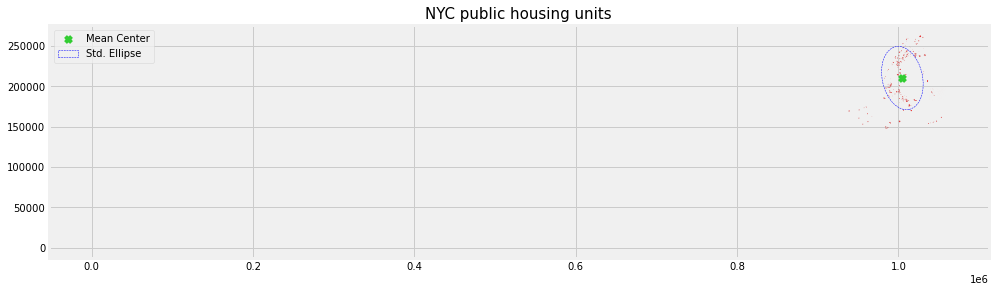

In [35]:
# add nyc public housing points to the map above

# centrographic statistics
nyhousing_mean_center = centrography.mean_center(nyc_public_housing[["long", "lat"]])
centrography.std_distance(nyc_public_housing[["long", "lat"]])
major1, minor1, rotation1 = centrography.ellipse(nyc_public_housing[["long", "lat"]])

# add these points to the map from above
fig, ax7 = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax7, alpha=0.3, color='black')
nyc_public_housing.plot(ax=ax7, alpha=0.3, color='black')
nyc_public_housing.plot(ax=ax7, 
            markersize=20, 
            color='red', 
            marker='o')

# set title
ax7.set_title('NYC public housing units', fontsize=15)

# plot mean center
ax7.scatter(*nyhousing_mean_center, color="limegreen", marker="x", label="Mean Center")


# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=nyhousing_mean_center,  # center the ellipse on our mean center
    width=major1 * 2,  # centrography.ellipse only gives half the axis
    height=minor1 * 2,
    angle=np.rad2deg(
        rotation1
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="blue",
    linestyle="--",
    label="Std. Ellipse",
)
ax7.add_patch(ellipse)

ax7.legend()
# Display
plt.show()

In [36]:
nyhousing_mean_center

array([1004924.19642296,  210313.78373731])

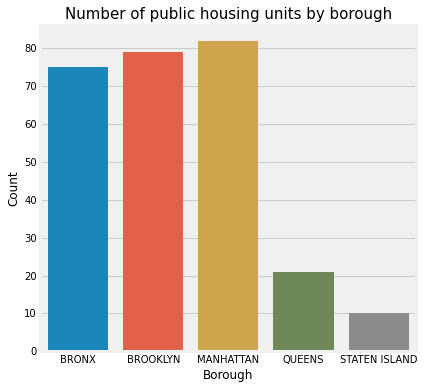

In [37]:
#Get a count by county
housing_by_borough = nyc_public_housing.groupby('borough').agg('count').reset_index()

#Plot the count by county
fig, ax1 = plt.subplots(1,1, figsize=(6,6)
                       )
sns.barplot(x='borough', y='developmen', data=housing_by_borough, ax=ax1)

ax1.set_title('Number of public housing units by borough', fontsize=15)
ax1.set_xlabel('Borough', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)

In [38]:
housing_by_borough#.columns

,borough,developmen,tds_num,geometry,long,lat
0,BRONX,75,75,75,75,75
1,BROOKLYN,79,79,79,79,79
2,MANHATTAN,82,82,82,82,82
3,QUEENS,21,21,21,21,21
4,STATEN ISLAND,10,10,10,10,10


# Non-spatial regressions

In [39]:
mpv_nyc.columns

Index(['name', 'age', 'gender', 'race', 'victim_image', 'date',
       'street_address', 'city', 'state', 'zip', 'county',
       'agency_responsible', 'ori', 'cause_of_death', 'circumstances',
       'disposition_official', 'officer_charged', 'news_urls',
       'signs_of_mental_illness', 'allegedly_armed', 'wapo_armed',
       'wapo_threat_level', 'wapo_flee', 'wapo_body_camera', 'wapo_id',
       'off_duty_killing', 'geography', 'mpv_id', 'fe_id', 'encounter_type',
       'initial_reason', 'officer_names', 'officer_races',
       'officer_known_past_shootings', 'call_for_service', 'tract',
       'urban_rural_uspsai', 'urban_rural_nchs',
       'hhincome_median_census_tract', 'latitude', 'longitude',
       'pop_total_census_tract', 'pop_white_census_tract',
       'pop_black_census_tract', 'pop_native_american_census_tract',
       'pop_asian_census_tract', 'pop_pacific_islander_census_tract',
       'pop_other_multiple_census_tract', 'pop_hispanic_census_tract',
       'congressio

In [44]:
mpv_nyc.officer_races.unique()

array([nan, 'white', 'Asian', 'White, White', 'Hispanic', 'Black'],
      dtype=object)

Variables of interest for linear regression: 

Group_by census tract?

Categorical variables: group_by('tract'), population_white, population_black, controlling for the total population, cause of death, race, officer charged, officer_race

Continuous variables: population_white, black, total, age

In [43]:
mpv_nyc_new = mpv_nyc.dropna(subset=['race'])
mpv_nyc_new.race.unique()

array(['Hispanic', 'Black', 'White', 'Unknown race', 'Asian'],
      dtype=object)

In [42]:
# performing the regression
# and fitting the model
sm1 = sm.OLS(mpv_nyc_new.age, mpv_nyc_new.race).fit()

# printing the summary table
print(sm1.summary())


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and None. The data was
237      39.0
323      42.0
404      29.0
729      60.0
730      19.0
         ... 
10971    17.0
11046     1.0
11047    33.0
11142    16.0
11326    37.0
Name: age, Length: 97, dtype: float64
and
 237      Hispanic
323         Black
404         Black
729      Hispanic
730         Black
           ...   
10971       Black
11046       Black
11047       Black
11142       Black
11326       Black
Name: race, Length: 97, dtype: object
before. After,
[39. 42. 29. 60. 19. 51. 25. 53. 47. 27. 26. nan 65. 24. 24. 53. nan 18.
 52. 35. 41. 24. 20. 33. 19. 37. 36. 29. 31. 30. 33. 27. 39. 29. 27. 58.
 42. 32. 42. 32. 50. 54. 34. 19. 52. 69. 67. 31. 32. 34. 18. 17. 28. 18.
 63. 21. 35. 49. 66. 42. 39. 37. 25. 46. 32. 30. 38. 58. 19. 51. 51. 24.
 30. 49. 28. 29. 32. 28. 47. 51. 22. 32. 43. 39. 45. 86. 44. 22. 26. 50.
 46. 28. 17.  1. 33. 16. 37.]
['Hispanic' 'Black' 'Black' 'Hispanic' 'Black' 'White' 'Black' 'Black'
 'Black' 'Unknown race' 'Black' 'Unknown race' 'White' 'Asian' 'Hispanic'
 'Unknown race' 'Unknown race' 'Hispanic' 'Hispanic' 'Black' 'Black'
 'Black' 'Hispanic' 'Black' 'Black' 'Black' 'Black' 'Hispanic' 'Black'
 'Black' 'White' 'Black' 'Black' 'Unknown race' 'Unknown race'
 'Unknown race' 'Hispanic' 'Black' 'White' 'Black' 'Unknown race' 'White'
 'Black' 'Black' 'Black' 'Hispanic' 'Black' 'Black' 'Black' 'Black'
 'Hispanic' 'Black' 'Black' 'Hispanic' 'Black' 'Black' 'Hispanic'
 'Hispanic' 'Black' 'Black' 'Black' 'Black' 'Black' 'White' 'Black'
 'Black' 'Black' 'White' 'Black' 'Hispanic' 'Black' 'Black' 'White'
 'Black' 'Black' 'Black' 'Black' 'White' 'Hispanic' 'Hispanic' 'Black'
 'White' 'Black' 'Black' 'Black' 'White' 'Black' 'Black' 'Unknown race'
 'Black' 'Black' 'Unknown race' 'Black' 'Black' 'Black' 'Black' 'Black'].